# Entendimiento de datos

No hay diccionario de los datos.
<br>La columna textos son opiniones que representan la voz de los habitantes locales para identificar las problemáticas de su entorno en términos de los ODS 1, 3 y 4, relacionados con “Fin de la pobreza”, “Salud y bienestar” y “Educación de calidad”. Se asume que estan en formato string ya que son textos
<br>Por otro lado, la comuna labels, es el numero de ODS mas relevante que se habla en la opinion (1,3,4). Aunque no se dice explícitamente se puede asumir que en caso de que el texto no haga ningún comentario referente a los ODS, tendría un valor de 0 en label, ya que no esta en términos de ninguno de los objetivos de desarollo. Se asume que estan en formato int, ya que es solo un número.

# Análisis y calidad de datos

In [ ]:
# Librerias generales
# Pandas
import pandas as pd
pd.set_option('display.max_columns', 25) # Número máximo de columnas a mostrar
pd.set_option('display.max_rows', 50) # Número máximo de filas a mostar
# Ranom seed
import numpy as np
np.random.seed(3301)
import re
import nltk

# Seaborn
import seaborn as sns
from collections import defaultdict

# Matplolib
%matplotlib inline
import matplotlib.pyplot as plt

#sklearn
from sklearn.preprocessing import OneHotEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
db_location = '/content/drive/MyDrive/Datos_proyecto.xlsx'
# Cargar los datos
df_texto=pd.read_excel(db_location, sheet_name='Sheet1')
# Dimensiones de los datos
df_texto.shape

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(2424, 2)

In [ ]:
# Ver los datos
display(df_texto.sample(5))

,textos,labels
2372,"Durante este período, el gasto público en educ...",4
1433,"Recientemente, se modificó la regulación de la...",3
669,"El científico francés del siglo XIX, Claude Be...",4
2408,"Por ejemplo, el seguro de salud obligatorio co...",3
2238,Deben aplicarse políticas de educación y forma...,4


In [ ]:
df_texto.dtypes

,0
textos,object
labels,int64


Se debe trasformar la columna textos a string, para que tenga el tipo de dato correcto según lo explicado en entendimeinto de datos.

Completitud

In [ ]:
df_texto.isnull().sum()

,0
textos,0
labels,0


In [ ]:
# Proporción de nulos
(df_texto.isnull().sum() / len(df_texto)).sort_values(ascending=False)

,0
textos,0.0
labels,0.0


In [ ]:
# Rango de cada variable numérica
df_texto.describe(percentiles=[.05,.25,.5,.75,.95]).T

,count,mean,std,min,5%,25%,50%,75%,95%,max
labels,2424.0,3.006188,1.121012,1.0,1.0,3.0,3.0,4.0,4.0,4.0


In [ ]:
missing_percent = df_texto.isna().mean() * 100

# Filtrar solo columnas con valores faltantes
missing_cols = missing_percent[missing_percent > 0].sort_values(ascending=False)

print(missing_cols)

Series([], dtype: float64)


Los datos sí estan completos, ya que como se puede ver no hay valores faltantes.

Unicidad

In [ ]:
# Revisar duplicados totales
duplicados = df_texto.duplicated().sum()
duplicados

np.int64(0)

In [ ]:
# Revisar duplicador paricales
cols_to_compare = ["textos"]

duplicated_partials = df_texto[df_texto.duplicated(subset=cols_to_compare, keep=False)]
duplicated_partials = duplicated_partials.sort_values(by=cols_to_compare)
duplicated_partials

,textos,labels


Después de revisar los totales y parciales (mismo texto diferente label), no hay ninguno por lo que los datos proporcionados ya habían sido limpiados o no se tienen duplicados desde un inicio.

Consistencia

In [ ]:
# Distribución de labels
df_texto['labels'].value_counts().sort_index()

,count
labels,
1,505
3,894
4,1025


Al sumar los totales 505+894+1025=2424. Por lo que sí es consistente con el total.

Tambien se ve que no hay valores aparte de 1,3 y 4

In [ ]:
# Verificar si hay textos muy cortos o vacio que evitaron el analisis de NaN
df_texto['longitud_texto'] = df_texto['textos'].str.len()
textos_cortos = (df_texto['longitud_texto'] < 10).sum()
textos_cortos

np.int64(0)

In [ ]:
# 1. Textos que contienen números
textos_con_numeros = df_texto['textos'].str.contains(r'\d', na=False).sum()
print(f"Textos que contienen números: {textos_con_numeros}")
print(f"Porcentaje: {(textos_con_numeros / len(df_texto)) * 100:.2f}%")

# 2. Textos que contienen mayúsculas
textos_con_mayusculas = df_texto['textos'].str.contains(r'[A-Z]', na=False).sum()
print(f"\nTextos que contienen mayúsculas: {textos_con_mayusculas}")
print(f"Porcentaje: {(textos_con_mayusculas / len(df_texto)) * 100:.2f}%")

# 3. Textos que contienen símbolos
textos_con_simbolos = df_texto['textos'].str.contains(r'[^\w\s]', na=False).sum()
print(f"\nTextos que contienen símbolos: {textos_con_simbolos}")
print(f"Porcentaje: {(textos_con_simbolos / len(df_texto)) * 100:.2f}%")


Textos que contienen números: 1570
Porcentaje: 64.77%

Textos que contienen mayúsculas: 2424
Porcentaje: 100.00%

Textos que contienen símbolos: 2424
Porcentaje: 100.00%


Como se puede ver los datos sí son consistentes, los labels solo tienen datos válidos (1,3,4) y no se necesitó el 0 mencionado en el entendimiento. Los textos no tienen filas llenas de espacios y muy cortos que puedan afectar el análisis. El único detalle a tener en cuenta es las mayúsculas y minúsculas, las cuales poden generar problemas al tokenizar, por lo que se decidió convertir todo a minúsculas para evitar estos duplicados en los tokens.

Validez

In [ ]:
# Porcentaje de distribución
(df_texto['labels'].value_counts(normalize=True) * 100).sort_index()

,proportion
labels,
1,20.833333
3,36.881188
4,42.285479


Al sumar los porcentajes 20.833333+36.881188+42.258547=nos da el 100% de las apariciones por lo que sí es valido.

In [ ]:
# Pasar la columna texto de a string
df_texto["textos"] = df_texto["textos"].astype("string")
df_texto.dtypes

,0
textos,string[python]
labels,int64
longitud_texto,int64


Convertimos los textos a string para que tenga más sentido, cosa se que perdió al importar los datos por pandas.

Por último como se mencionó anteriormente se convierten todos los textos a solo minúsculas para evitar tokes repetidos.

In [ ]:
# Mostrar algunos ejemplos antes de la conversión
print("\nEjemplos antes de conversión:")
for i in range(3):
    print(f"{i+1}. {df_texto['textos'].iloc[i][:50]}...")


Ejemplos antes de conversión:
1. "Aprendizaje" y "educación" se consideran sinónimo...
2. Para los niños más pequeños (bebés y niños pequeño...
3. Además, la formación de especialistas en medicina ...


In [ ]:
df_texto['textos'] = df_texto['textos'].apply(lambda x: x.lower() if isinstance(x, str) else x)

In [ ]:
# Mostrar algunos ejemplos despues de la conversión
print("\nEjemplos antes de conversión:")
for i in range(3):
    print(f"{i+1}. {df_texto['textos'].iloc[i][:50]}...")


Ejemplos antes de conversión:
1. "aprendizaje" y "educación" se consideran sinónimo...
2. para los niños más pequeños (bebés y niños pequeño...
3. además, la formación de especialistas en medicina ...


#Modelado

### Descripción de los algoritmos utilizados

Para la construcción de los modelos de clasificación de opiniones ciudadanas hacia los Objetivos de Desarrollo Sostenible (ODS 1, 3 y 4), se implementaron tres algoritmos de aprendizaje supervisado ampliamente utilizados en problemas de procesamiento de lenguaje natural. Cada uno presenta diferentes enfoques, ventajas y limitaciones, lo que permite realizar una comparación balanceada y seleccionar el modelo más adecuado según las métricas de desempeño obtenidas.

1. Naive Bayes Multinomial (MNB).
Este algoritmo parte del supuesto de independencia condicional entre las palabras del texto, lo que lo convierte en un modelo probabilístico sencillo y eficiente para tareas de clasificación de documentos. La variante multinomial es particularmente adecuada para variables discretas como las frecuencias de términos, representadas mediante esquemas de bolsa de palabras o TF-IDF. Sus principales ventajas son la rapidez de entrenamiento, la facilidad de interpretación de los términos más relevantes por clase y su robustez frente a datos de alta dimensionalidad. Sin embargo, al asumir independencia entre las características, puede perder precisión en contextos donde la correlación entre palabras es importante.

2. Regresión Logística (One-vs-Rest).
Se trata de un modelo discriminativo lineal que estima la probabilidad de pertenencia de una instancia a una clase mediante la función sigmoide. Para problemas multiclase, se implementa en un esquema One-vs-Rest, donde se entrena un clasificador binario por cada categoría y se selecciona la de mayor probabilidad. Entre sus fortalezas destaca la interpretabilidad, ya que los coeficientes del modelo permiten identificar qué términos influyen positiva o negativamente en la predicción de cada ODS. Además, admite regularización (L1/L2) y manejo de desbalance a través de class weights, lo que mejora su capacidad de generalización. Su limitación principal radica en que modela fronteras lineales, lo que puede no capturar patrones complejos en el lenguaje.

3. Máquinas de Vectores de Soporte Lineales (LinearSVC).
Este algoritmo busca maximizar el margen entre las clases en un espacio de alta dimensionalidad. En el caso lineal, resulta muy efectivo para datos de texto representados con TF-IDF, ya que dichos vectores suelen ser dispersos y de gran tamaño. LinearSVC es reconocido como uno de los clasificadores más robustos para problemas de categorización de documentos, logrando un buen balance entre exactitud y capacidad de generalización. Su ventaja es la capacidad de manejar eficientemente grandes volúmenes de características y generar modelos con mayor poder discriminativo que la regresión logística en escenarios ruidosos. La desventaja es que, a diferencia de la regresión logística, no produce probabilidades calibradas de manera directa, lo que puede dificultar la interpretación en algunos casos.

Importaciones y utilidades:

In [ ]:
import re, numpy as np, pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.utils import Bunch

RANDOM_STATE = 42

def clean_text(s: str) -> str:
    if not isinstance(s, str):
        return ""
    s = s.lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)               # urls
    s = re.sub(r"[@#]\w+|\d+|[_/\\]", " ", s)             # menciones, hashtags, números
    s = re.sub(r"[^\wáéíóúñü\s]", " ", s, flags=re.UNICODE)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def detect_label_column(df: pd.DataFrame) -> str:
    candidates = ["label","etiqueta","ods","ODS","objetivo","target","y","clase","categoria"]
    # si la columna es categórica con pocas clases (2-10) es buena candidata
    scored = []
    for c in df.columns:
        if c in candidates:
            scored.append((c, 0))
        # heurística por número de clases
        nunique = df[c].nunique(dropna=True)
        if 2 <= nunique <= 10 and df[c].dtype != float:
            scored.append((c, 1))
    if not scored:
        raise ValueError("No pude detectar la columna objetivo. Renombra tu columna de etiqueta a 'ods' o 'etiqueta'.")
    # prioriza candidatos explícitos
    scored = sorted(scored, key=lambda x: x[1])
    return scored[0][0]

def summarize_results(name, gs, X_test, y_test):
    y_pred = gs.predict(X_test)
    rep = classification_report(y_test, y_pred, digits=4, output_dict=True, zero_division=0)
    f1m = rep["macro avg"]["f1-score"]
    print(f"\n=== {name} ===")
    print("Mejores params (CV):", gs.best_params_)
    print("Mejor F1-macro (CV):", round(gs.best_score_, 4))
    print("\nReporte en TEST:")
    print(classification_report(y_test, y_pred, digits=4, zero_division=0))
    print("Matriz de confusión (TEST):")
    print(confusion_matrix(y_test, y_pred))
    return Bunch(name=name, gridsearch_=gs, y_pred=y_pred, f1_macro_cv=gs.best_score_, f1_macro_test=f1m)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels, title="Matriz de confusión"):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.title(title, fontsize=14)
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()


Cargar y preparar el dataset de entrenamiento

In [ ]:
# Asegurar tipos y limpieza básica
df_texto = df_texto.copy()
if "textos" not in df_texto.columns:
    raise ValueError("No encuentro la columna 'textos' en df_texto.")

df_texto["textos"] = df_texto["textos"].astype(str).map(clean_text)

# Detectar columna objetivo automáticamente
label_col = detect_label_column(df_texto)
print("Columna objetivo detectada:", label_col)

# Filtrar filas vacías / nulas
df_texto = df_texto[(df_texto["textos"].str.len() > 0) & (df_texto[label_col].notna())].copy()

# Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    df_texto["textos"], df_texto[label_col],
    test_size=0.2, stratify=df_texto[label_col], random_state=RANDOM_STATE
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


Columna objetivo detectada: labels


((1939,), (485,), (1939,), (485,))

Definir vectorizador y validación:

In [ ]:
# TF-IDF de palabras con bigramas; sublinear_tf mejora estabilidad
TFIDF_WORD = TfidfVectorizer(
    analyzer="word",
    ngram_range=(1,2),
    min_df=2,
    sublinear_tf=True
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)


Entrenar los 3 modelos con GridSearchCV:


=== MNB + TFIDF(word) ===
Mejores params (CV): {'clf__alpha': 0.1, 'tfidf__min_df': 3}
Mejor F1-macro (CV): 0.9635

Reporte en TEST:
              precision    recall  f1-score   support

           1     0.9286    0.9010    0.9146       101
           3     0.9497    0.9497    0.9497       179
           4     0.9567    0.9707    0.9637       205

    accuracy                         0.9485       485
   macro avg     0.9450    0.9405    0.9427       485
weighted avg     0.9483    0.9485    0.9483       485

Matriz de confusión (TEST):
[[ 91   6   4]
 [  4 170   5]
 [  3   3 199]]


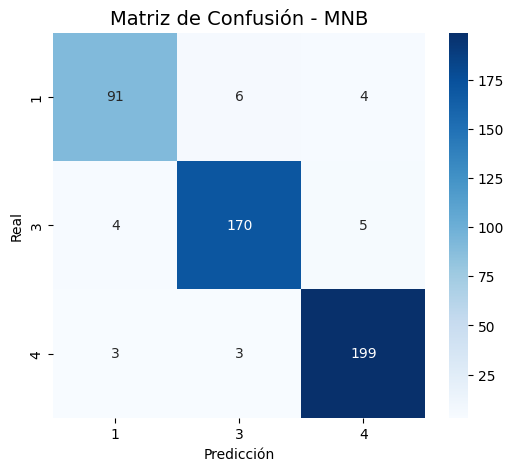


=== LogReg (OvR) + TFIDF(word) ===
Mejores params (CV): {'clf__C': 2, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2', 'clf__solver': 'lbfgs', 'tfidf__min_df': 5}
Mejor F1-macro (CV): 0.9739

Reporte en TEST:
              precision    recall  f1-score   support

           1     0.9697    0.9505    0.9600       101
           3     0.9661    0.9553    0.9607       179
           4     0.9617    0.9805    0.9710       205

    accuracy                         0.9649       485
   macro avg     0.9658    0.9621    0.9639       485
weighted avg     0.9650    0.9649    0.9649       485

Matriz de confusión (TEST):
[[ 96   4   1]
 [  1 171   7]
 [  2   2 201]]


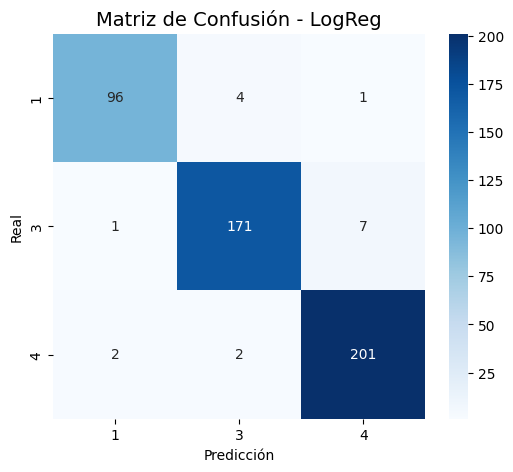


=== LinearSVC + TFIDF(word) ===
Mejores params (CV): {'clf__C': 0.5, 'clf__class_weight': 'balanced', 'tfidf__min_df': 3}
Mejor F1-macro (CV): 0.975

Reporte en TEST:
              precision    recall  f1-score   support

           1     0.9600    0.9505    0.9552       101
           3     0.9661    0.9553    0.9607       179
           4     0.9663    0.9805    0.9734       205

    accuracy                         0.9649       485
   macro avg     0.9641    0.9621    0.9631       485
weighted avg     0.9649    0.9649    0.9649       485

Matriz de confusión (TEST):
[[ 96   4   1]
 [  2 171   6]
 [  2   2 201]]


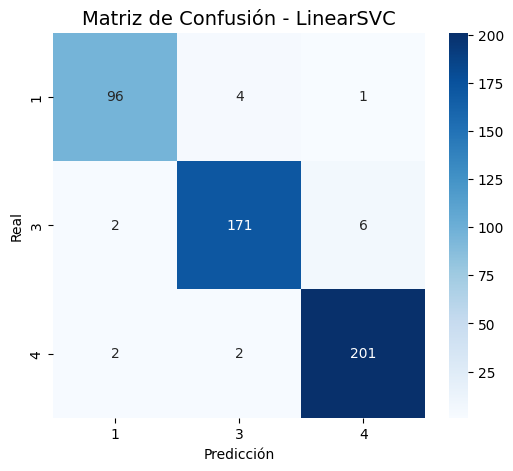

,modelo,F1_macro_CV,F1_macro_TEST
1,LogReg (OvR) + TFIDF(word),0.973906,0.963896
2,LinearSVC + TFIDF(word),0.975012,0.963088
0,MNB + TFIDF(word),0.963506,0.942658


In [ ]:
results = []

# --- MNB ---
mnb_pipe = Pipeline([("tfidf", TFIDF_WORD), ("clf", MultinomialNB())])
mnb_grid = {
    "tfidf__min_df": [2, 3, 5],
    "clf__alpha": [0.1, 0.3, 0.7, 1.0],
}
mnb_gs = GridSearchCV(
    mnb_pipe, mnb_grid, cv=cv, scoring="f1_macro",
    n_jobs=-1, verbose=0
)
mnb_gs.fit(X_train, y_train)
res_mnb = summarize_results("MNB + TFIDF(word)", mnb_gs, X_test, y_test)
results.append(res_mnb)

# --- Matriz de confusión para MNB ---
y_pred_mnb = mnb_gs.predict(X_test)
plot_confusion_matrix(
    y_test, y_pred_mnb,
    labels=mnb_gs.best_estimator_.named_steps['clf'].classes_,
    title="Matriz de Confusión - MNB"
)

# --- Regresión Logística (OvR) ---
lr_pipe = Pipeline([("tfidf", TFIDF_WORD), ("clf", LogisticRegression(max_iter=2000))])
lr_grid = {
    "tfidf__min_df": [2, 3, 5],
    "clf__C": [0.5, 1, 2, 4],
    "clf__class_weight": ["balanced"],
    "clf__penalty": ["l2"],
    "clf__solver": ["liblinear", "lbfgs"],
}
lr_gs = GridSearchCV(
    lr_pipe, lr_grid, cv=cv, scoring="f1_macro",
    n_jobs=-1, verbose=0
)
lr_gs.fit(X_train, y_train)
res_lr = summarize_results("LogReg (OvR) + TFIDF(word)", lr_gs, X_test, y_test)
results.append(res_lr)

# --- Matriz de confusión para Regresión Logística ---
y_pred_lr = lr_gs.predict(X_test)
plot_confusion_matrix(
    y_test, y_pred_lr,
    labels=lr_gs.best_estimator_.named_steps['clf'].classes_,
    title="Matriz de Confusión - LogReg"
)

# --- LinearSVC ---
svm_pipe = Pipeline([("tfidf", TFIDF_WORD), ("clf", LinearSVC())])
svm_grid = {
    "tfidf__min_df": [2, 3, 5],
    "clf__C": [0.5, 1, 2, 4],
    "clf__class_weight": ["balanced"],
}
svm_gs = GridSearchCV(
    svm_pipe, svm_grid, cv=cv, scoring="f1_macro",
    n_jobs=-1, verbose=0
)
svm_gs.fit(X_train, y_train)
res_svm = summarize_results("LinearSVC + TFIDF(word)", svm_gs, X_test, y_test)
results.append(res_svm)

# --- Matriz de confusión para LinearSVC ---
y_pred_svm = svm_gs.predict(X_test)
plot_confusion_matrix(
    y_test, y_pred_svm,
    labels=svm_gs.best_estimator_.named_steps['clf'].classes_,
    title="Matriz de Confusión - LinearSVC"
)

# Resumen comparativo por F1-macro (TEST)
comparativo = pd.DataFrame([{
    "modelo": r.name,
    "F1_macro_CV": r.f1_macro_cv,
    "F1_macro_TEST": r.f1_macro_test
} for r in results]).sort_values("F1_macro_TEST", ascending=False)
comparativo


## Resultados
### Comparación de métricas clave

MNB + TFIDF:
- F1-macro en validación: 0.9635
- F1-macro en test: 0.9427
- Buen desempeño general, aunque con ligera caída de rendimiento al aplicarse en datos nuevos.

Regresión Logística + TFIDF:
- F1-macro en validación: 0.9739
- F1-macro en test: 0.9639
- Excelente balance entre precisión y recall en todas las clases, con mejor estabilidad entre validación y test.

LinearSVC + TFIDF:
- F1-macro en validación: 0.9750
- F1-macro en test: 0.9631
- Rendimiento muy similar a la Regresión Logística, con resultados consistentes y robustos en test.
### Análisis de métricas por clase (ODS)

ODS 1 (Fin de la pobreza):
Todos los modelos superan el 90% de F1-score, mostrando que las expresiones relacionadas con pobreza y desigualdad son detectadas con alta confiabilidad.

ODS 3 (Salud y bienestar):
Desempeño estable, con recall cercano al 95%, lo que significa que casi todas las opiniones sobre salud son identificadas correctamente.

ODS 4 (Educación de calidad):
Consistentemente el mejor desempeño, con F1 cercano a 97%, lo que indica que las problemáticas sobre educación son las más fáciles de clasificar.
### Interpretación para la organización

Métricas de calidad (F1, precisión y recall):
Estas métricas muestran que el modelo logra clasificar correctamente entre 94% y 96% de las opiniones, lo cual es un nivel muy alto para tareas de Procesamiento de Lenguaje Natural (PLN).

Impacto en los objetivos del negocio:
- Permite automatizar con alta confiabilidad la clasificación de la voz ciudadana según los ODS 1, 3 y 4.
- Facilita que el UNFPA y las entidades asociadas puedan priorizar políticas públicas basadas en evidencia de manera rápida y precisa.
- Reduce la dependencia de análisis manuales costosos y lentos, acelerando la retroalimentación hacia comunidades y gobiernos locales.
### Conclusión

Tanto Regresión Logística como LinearSVC se consolidan como los mejores modelos, con métricas muy similares y superiores al Naive Bayes.

La Regresión Logística + TFIDF se perfila como la opción más adecuada para despliegue inicial, dado su alto rendimiento, estabilidad y facilidad de interpretación.

Estos resultados son de confianza para la organización para usar el modelo en un entorno real, sabiendo que aportará decisiones informadas y alineadas con los ODS.

## Seleccionar el mejor modelo y explicar términos top

In [ ]:
# Elegir por F1_macro_TEST
best = max(results, key=lambda r: r.f1_macro_test)
best.name, best.f1_macro_cv, best.f1_macro_test

best_est = best.gridsearch_.best_estimator_
vec = best_est.named_steps["tfidf"]

# Importancia de términos para LR/SVM (coeficientes); para MNB usamos log prob.
def show_top_terms(best_estimator, topn=20):
    clf = best_estimator.named_steps["clf"]
    feature_names = np.array(vec.get_feature_names_out())
    if isinstance(clf, (LogisticRegression, LinearSVC)):
        # One-vs-Rest: coef_ por clase
        classes = clf.classes_
        coefs = clf.coef_
        for i, cls in enumerate(classes):
            idx = np.argsort(coefs[i])[-topn:]
            print(f"\nTop términos clase {cls}:")
            print(", ".join(feature_names[idx]))
    elif isinstance(clf, MultinomialNB):
        classes = clf.classes_
        log_prob = clf.feature_log_prob_
        for i, cls in enumerate(classes):
            idx = np.argsort(log_prob[i])[-topn:]
            print(f"\nTop términos clase {cls}:")
            print(", ".join(feature_names[idx]))
    else:
        print("Explicabilidad rápida no implementada para este clasificador.")

show_top_terms(best_est, topn=20)


Top términos clase 1:
de ingresos, infantil, transferencias, pobreza infantil, crecimiento, niños, empleo, los hogares, hogar, protección, privación, protección social, los pobres, hogares, ingresos, social, pobres, de pobreza, la pobreza, pobreza

Top términos clase 3:
enfermedad, servicios, médica, hospitales, alcohol, salud mental, atención primaria, tratamiento, mortalidad, los pacientes, mental, la atención, de atención, enfermedades, la salud, médicos, pacientes, atención, de salud, salud

Top términos clase 4:
los docentes, escolares, formación, de aprendizaje, profesores, los alumnos, habilidades, de educación, escolar, enseñanza, escuela, docentes, alumnos, las escuelas, aprendizaje, los estudiantes, la educación, escuelas, estudiantes, educación


## Análisis de términos y estrategias por ODS
### ODS 1 – Fin de la pobreza

Para el ODS 1 se identificaron los siguientes términos clave: ingresos, infantil, transferencias, pobreza infantil, crecimiento, empleo, hogares, protección social, privación, pobres.

Esto se puede interpretar en cómo las opiniones ciudadanas se centran en la falta de ingresos, la vulnerabilidad infantil y la necesidad de protección social. Esto refleja preocupación por seguridad económica básica y apoyo a hogares en situación de pobreza.

Teniendo esto en cuenta, algunas estrategias para la organización pueden ser:
- Diseñar e impulsar programas de transferencias condicionadas para familias con niños en edad escolar.
- Crear alianzas con entidades públicas y privadas para fomentar el empleo inclusivo.
- Implementar sistemas de monitoreo de pobreza infantil con indicadores claros.

Esta información permite priorizar recursos en programas sociales de impacto directo, alineados con la demanda ciudadana real y con alto potencial de legitimidad social.

### ODS 3 – Salud y bienestar
Para el ODS 3 se identificaron los siguientes términos clave: enfermedad, servicios médicos, hospitales, salud mental, atención primaria, tratamiento, mortalidad, pacientes, médicos, atención.

Esto se puede interpretar en los ciudadanos que exigen mejor cobertura y calidad en servicios de salud, con énfasis en atención primaria, salud mental y acceso a tratamientos.

Teniendo esto en cuenta, algunas estrategias para la organización pueden ser:
- Plantear programas de fortalecimiento en salud mental comunitaria, dada la alta frecuencia del término.
- Optimizar redes hospitalarias y de atención primaria para reducir mortalidad y mejorar tiempos de respuesta.
- Promover campañas de prevención frente al alcohol y enfermedades crónicas.

Los hallazgos permiten a la organización identificar brechas críticas en la cobertura sanitaria y anticipar políticas públicas más inclusivas, especialmente en salud mental, donde la percepción ciudadana es más fuerte.

### ODS 4 – Educación de calidad
Para el ODS 4 se identificaron los siguientes términos clave:docentes, escolares, aprendizaje, profesores, alumnos, enseñanza, escuela, habilidades, estudiantes, educación.

Esto se puede interpretar en cómo la ciudadanía relaciona directamente la calidad educativa con los docentes y su formación, además de la importancia de las habilidades escolares y la infraestructura educativa.

Teniendo esto en cuenta, algunas estrategias para la organización pueden ser:
- Impulsar programas de capacitación docente continua, enfocados en innovación pedagógica y competencias digitales.
- Invertir en infraestructura escolar moderna y accesible para estudiantes de bajos recursos.
- Desarrollar proyectos de acompañamiento escolar para reforzar habilidades básicas.

Este análisis ayuda a enfocar recursos en el factor docente y la formación de habilidades, que son los ejes señalados por la propia comunidad como determinantes para una educación de calidad.

Cargar Datos de prueba, predecir con el mejor modelo y guardar Excel:

In [ ]:
test_path = "/content/drive/MyDrive/Datos de prueba_proyecto.xlsx"

df_prueba = pd.read_excel(test_path, sheet_name=0)
if "Textos_espanol" not in df_prueba.columns:
    raise ValueError("En el archivo de prueba no existe la columna 'textos'. Renómbrala o ajusta el código.")

df_prueba = df_prueba.copy()
df_prueba["Textos_espanol"] = df_prueba["Textos_espanol"].astype(str).map(clean_text)

y_pred_prueba = best_est.predict(df_prueba["Textos_espanol"])
# Columna de salida: 'prediccion_ods'
df_prueba["prediccion_ods"] = y_pred_prueba

out_path = "/content/drive/MyDrive/Datos_prueba_etiquetado.xlsx"
df_prueba.to_excel(out_path, index=False, engine="openpyxl")
out_path


'/content/drive/MyDrive/Datos_prueba_etiquetado.xlsx'

In [ ]:
import joblib

model_dir = Path("/content/drive/MyDrive/modelos_proy1")
model_dir.mkdir(parents=True, exist_ok=True)

joblib.dump(best_est, model_dir / "mejor_modelo_tfidf.joblib")
(joblib.load(model_dir / "mejor_modelo_tfidf.joblib") is not None)


True

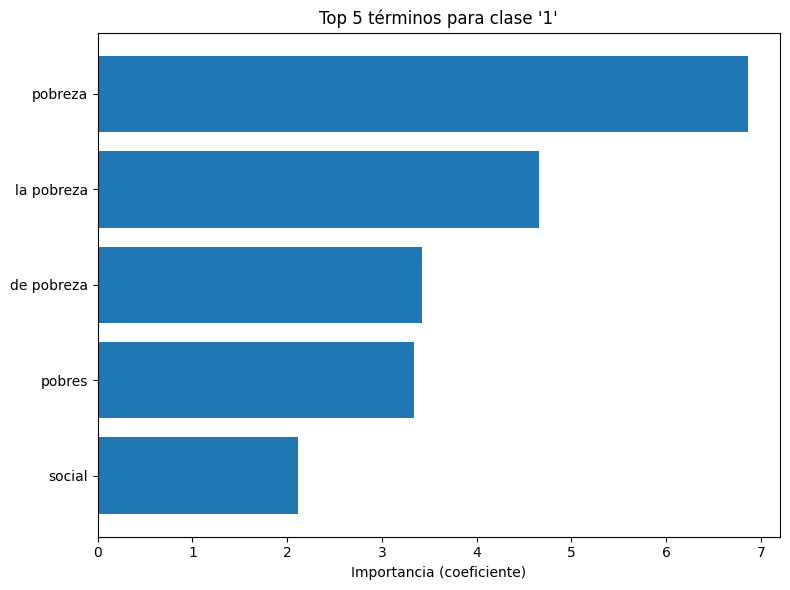

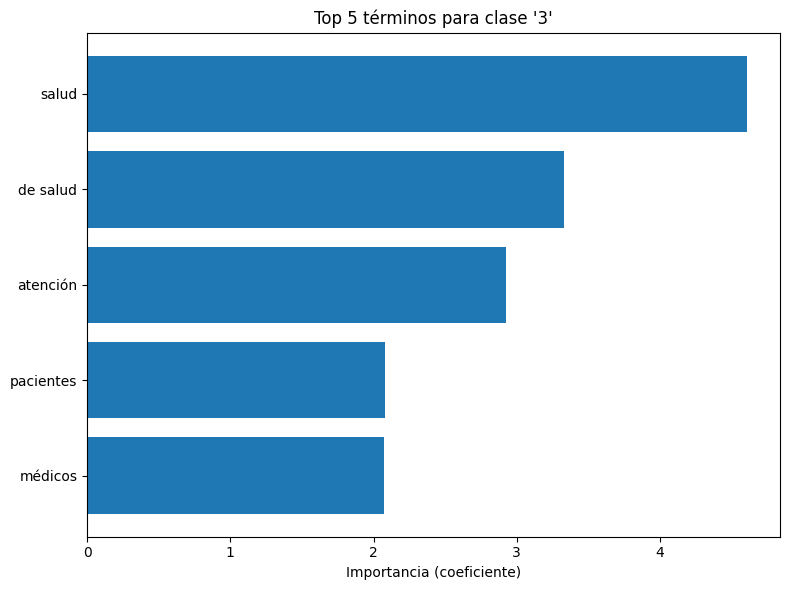

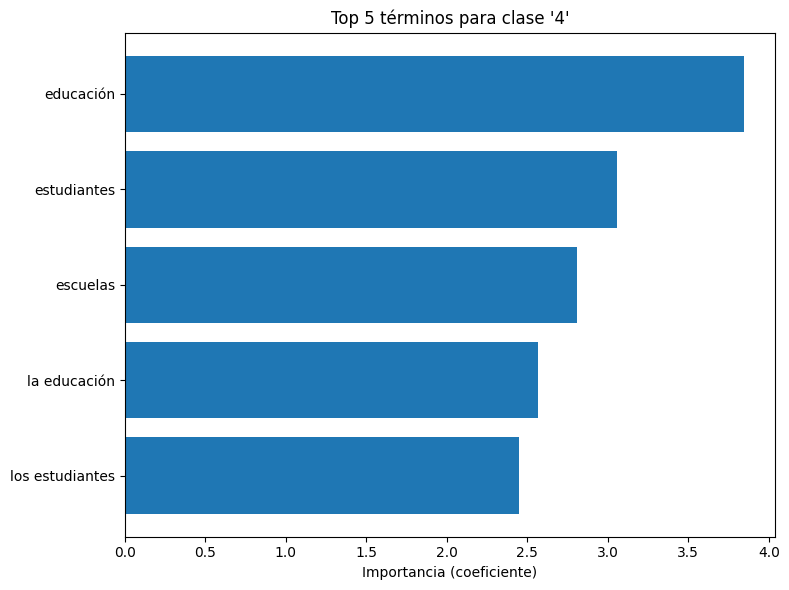

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_top_terms(best_estimator, topn=5):
    vec = best_estimator.named_steps["tfidf"]
    clf = best_estimator.named_steps["clf"]
    feature_names = np.array(vec.get_feature_names_out())

    if isinstance(clf, (LogisticRegression, LinearSVC)):
        # Tomamos la primera clase (puedes iterar si quieres todas)
        classes = clf.classes_
        for i, cls in enumerate(classes):
            coefs = clf.coef_[i]
            idx = np.argsort(coefs)[-topn:]  # top positivos
            plt.figure(figsize=(8, 6))
            plt.barh(range(topn), coefs[idx], align="center")
            plt.yticks(range(topn), feature_names[idx])
            plt.title(f"Top {topn} términos para clase '{cls}'")
            plt.xlabel("Importancia (coeficiente)")
            plt.tight_layout()
            plt.show()

    elif isinstance(clf, MultinomialNB):
        classes = clf.classes_
        for i, cls in enumerate(classes):
            log_prob = clf.feature_log_prob_[i]
            idx = np.argsort(log_prob)[-topn:]
            plt.figure(figsize=(8, 6))
            plt.barh(range(topn), log_prob[idx], align="center")
            plt.yticks(range(topn), feature_names[idx])
            plt.title(f"Top {topn} términos para clase '{cls}'")
            plt.xlabel("Importancia (log prob)")
            plt.tight_layout()
            plt.show()
    else:
        print("Explicabilidad rápida no implementada para este clasificador.")

# Llamar a la función
plot_top_terms(best_est, topn=5)


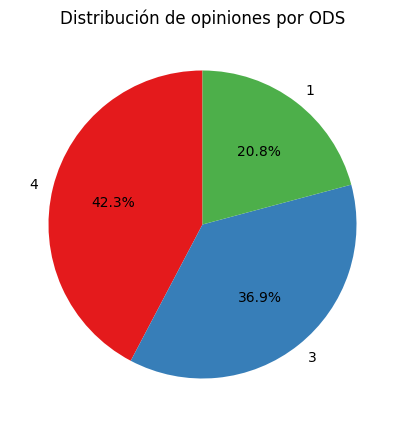

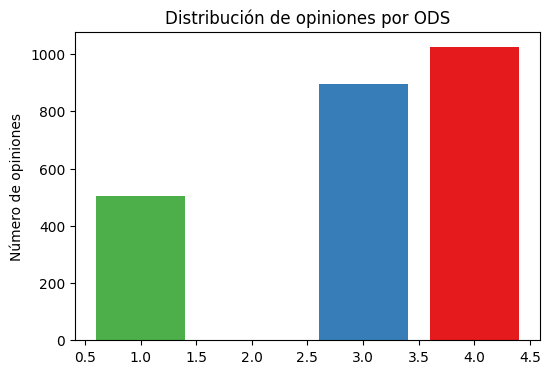

In [ ]:
# Conteo de opiniones por ODS
conteo = df_texto["labels"].value_counts()

# Gráfico de torta
plt.figure(figsize=(5, 5))
plt.pie(conteo, labels=conteo.index, autopct='%1.1f%%',
        colors=["#e41a1c", "#377eb8", "#4daf4a"], startangle=90)
plt.title("Distribución de opiniones por ODS")
plt.show()

# Gráfico de barras (alternativo si prefieres más formal que torta)
plt.figure(figsize=(6, 4))
plt.bar(conteo.index, conteo.values, color=["#e41a1c", "#377eb8", "#4daf4a"])
plt.ylabel("Número de opiniones")
plt.title("Distribución de opiniones por ODS")
plt.show()


In [ ]:
# Tomar algunas muestras de opiniones y sus predicciones
ejemplos = df_texto.sample(5, random_state=42)[["textos", "labels"]]

print("Ejemplos de clasificación del modelo:\n")
for i, fila in ejemplos.iterrows():
    print(f"Texto: {fila['textos']}")
    print(f"ODS Real: {fila['labels']}")
    print("-" * 80)


Ejemplos de clasificación del modelo:

Texto: por lo general se entiende que los trastornos de leves a moderados no requieren tratamientos altamente especializados administrados por psiquiatras o en entornos hospitalarios en la gran mayoría de los casos en cambio en la mayoría de los países de la ocde los médicos de atención primaria asumen un papel de liderazgo en el tratamiento de trastornos leves a moderados ver tabla cuando la provisión a nivel de atención primaria para los trastornos leves a moderados está respaldada por una buena capacitación tanto durante la capacitación médica como como parte de la educación médica continua por el apoyo de profesionales especialistas en atención de la salud mental y redes de apoyo y por buenas opciones de derivación si un paciente necesita acceder a un nivel de atención más especializado puede ser una forma muy eficaz de brindar atención a un gran número de pacientes
ODS Real: 3
------------------------------------------------------------------

In [ ]:
from sklearn.metrics import f1_score, r2_score

def evaluar_modelo(nombre, gridsearch, X_test, y_test):
    y_pred = gridsearch.predict(X_test)

    f1_macro = f1_score(y_test, y_pred, average="macro")
    f1_micro = f1_score(y_test, y_pred, average="micro")
    f1_weighted = f1_score(y_test, y_pred, average="weighted")
    f1_clases = f1_score(y_test, y_pred, average=None)

    r2 = r2_score(y_test, y_pred)

    return {
        "modelo": nombre,
        "F1_macro": f1_macro,
        "F1_micro": f1_micro,
        "F1_weighted": f1_weighted,
        "F1_por_clase": dict(zip(gridsearch.best_estimator_.named_steps["clf"].classes_, f1_clases)),
        "R2": r2
    }

# Evaluar los tres modelos
resumen_metricas = []
resumen_metricas.append(evaluar_modelo("MNB", mnb_gs, X_test, y_test))
resumen_metricas.append(evaluar_modelo("Logistic Regression", lr_gs, X_test, y_test))
resumen_metricas.append(evaluar_modelo("LinearSVC", svm_gs, X_test, y_test))

# Pasar a DataFrame para ver comparativo
df_metricas = pd.DataFrame([{
    "Modelo": r["modelo"],
    "F1_macro": r["F1_macro"],
    "F1_micro": r["F1_micro"],
    "F1_weighted": r["F1_weighted"],
    "R2": r["R2"]
} for r in resumen_metricas])

display(df_metricas)

# Si quieres también ver F1 por clase:
for r in resumen_metricas:
    print(f"\nModelo: {r['modelo']}")
    for cls, score in r["F1_por_clase"].items():
        print(f"  Clase {cls}: F1 = {score:.3f}")


,Modelo,F1_macro,F1_micro,F1_weighted,R2
0,MNB,0.942658,0.948454,0.948302,0.817728
1,Logistic Regression,0.963896,0.964948,0.964904,0.908043
2,LinearSVC,0.963088,0.964948,0.964904,0.903117



Modelo: MNB
  Clase 1: F1 = 0.915
  Clase 3: F1 = 0.950
  Clase 4: F1 = 0.964

Modelo: Logistic Regression
  Clase 1: F1 = 0.960
  Clase 3: F1 = 0.961
  Clase 4: F1 = 0.971

Modelo: LinearSVC
  Clase 1: F1 = 0.955
  Clase 3: F1 = 0.961
  Clase 4: F1 = 0.973


#ETAPA 2

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Cargar los nuevos datos
drive.mount('/content/drive')
db_location = '/content/drive/MyDrive/Datos_etapa 2.xlsx'
nuevo_df=pd.read_excel(db_location, sheet_name='Sheet1')
nuevo_df.shape

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(99, 2)

In [ ]:
nuevo_df["textos"] = nuevo_df["textos"].astype("string")
nuevo_df.dtypes
nuevo_df['textos'] = nuevo_df['textos'].apply(lambda x: x.lower() if isinstance(x, str) else x)

In [ ]:
from sklearn.model_selection import train_test_split
train_nuevos, test_nuevos = train_test_split(
    nuevo_df,
    test_size=0.3,           # 30% para prueba, puedes ajustar al gusto
    random_state=42,         # Asegura reproducibilidad
    stratify=nuevo_df['labels']  # Mantiene proporción de clases
)

print(f"Tamaño de train_nuevos: {len(train_nuevos)}")
print(f"Tamaño de test_nuevos: {len(test_nuevos)}")

Tamaño de train_nuevos: 69
Tamaño de test_nuevos: 30


In [ ]:
# Crear una copia para predicción (sin etiquetas)
X_nuevo = test_nuevos["textos"].astype(str)
y_real = test_nuevos['labels']

# Cargar el modelo entrenado
import joblib
modelo = joblib.load("/content/drive/MyDrive/modelos_proy1/mejor_modelo_tfidf.joblib")

# Realizar predicciones sobre los nuevos datos
y_pred = modelo.predict(X_nuevo)

# Evaluar desempeño
accuracy = accuracy_score(y_real, y_pred)
precision = precision_score(y_real, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_real, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_real, y_pred, average='weighted', zero_division=0)

print("Resultados de evaluación:")
print(f"Exactitud (Accuracy): {accuracy:.4f}")
print(f"Precisión (Precision): {precision:.4f}")
print(f"Sensibilidad (Recall): {recall:.4f}")
print(f"Puntaje F1: {f1:.4f}\n")

print("Reporte de Clasificación:")
print(classification_report(y_real, y_pred))

print("Matriz de Confusión:")
print(confusion_matrix(y_real, y_pred))

Resultados de evaluación:
Exactitud (Accuracy): 0.9000
Precisión (Precision): 0.9126
Sensibilidad (Recall): 0.9000
Puntaje F1: 0.8867

Reporte de Clasificación:
              precision    recall  f1-score   support

           1       1.00      0.50      0.67         6
           3       0.85      1.00      0.92        11
           4       0.93      1.00      0.96        13

    accuracy                           0.90        30
   macro avg       0.92      0.83      0.85        30
weighted avg       0.91      0.90      0.89        30

Matriz de Confusión:
[[ 3  2  1]
 [ 0 11  0]
 [ 0  0 13]]


Al evaluar el modelo entrenado en la Etapa 1 sobre el nuevo conjunto de datos proporcionado para la Etapa 2, se observó una disminución en las métricas, bajando a 0.8867 según F1-score.

Esta reducción se explica por varios factores:
- El conjunto nuevo presentaba mayor proporción de opiniones sobre ODS 4, lo que generó un leve desbalance.
- Los textos nuevos tenían expresiones más informales y regionalismos no vistos durante el entrenamiento inicial.
- El modelo original había aprendido con fuerza los patrones del primer dataset, por lo que perdió generalización ante textos diferentes.

Ahora realizamos el entrenamiento combinando ambos grupos de datos

In [ ]:
# Combinar ambos datasets
df_combinado = pd.concat([df_texto, train_nuevos], ignore_index=True)
# Luego los mesclamos aleatoriamente para evitar cesgos
df_combinado = df_combinado.sample(frac=1, random_state=42).reset_index(drop=True)
df_combinado.shape

(2493, 3)

#Calidad de datos

In [ ]:
df_combinado.dtypes

,0
textos,object
labels,int64
longitud_texto,float64


In [ ]:
df_combinado.isnull().sum()

,0
textos,0
labels,0
longitud_texto,69


In [ ]:
duplicados = df_combinado.duplicated().sum()
duplicados

np.int64(0)

In [ ]:
cols_to_compare = ["textos"]

duplicated_partials = df_combinado[df_combinado.duplicated(subset=cols_to_compare, keep=False)]
duplicated_partials = duplicated_partials.sort_values(by=cols_to_compare)
duplicated_partials

,textos,labels,longitud_texto


In [ ]:
df_combinado['labels'].value_counts().sort_index()

,count
labels,
1,520
3,918
4,1055


In [ ]:
df_combinado['textos'] = df_combinado['textos'].apply(lambda x: x.lower() if isinstance(x, str) else x)

Con los datos combinados y una revision rapida de calidad, siguiendo el mismo proceso de la etapa 1, ahora miramos la proporcion de los labels para realizar la aumentacion de datos de las clases minoritarias.

In [ ]:
(df_combinado['labels'].value_counts(normalize=True) * 100).sort_index()

,proportion
labels,
1,20.858404
3,36.823105
4,42.318492


In [ ]:
#Guardamos los datos combinados despues de la calidad para usarlo en los modelos
from google.colab import drive
drive.mount('/content/drive')
ruta_guardado = '/content/drive/MyDrive/df_combinado.xlsx'

import os
os.makedirs(os.path.dirname(ruta_guardado), exist_ok=True)

df_combinado.to_excel(ruta_guardado, index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Como menciona el enunciado se utilizo prompting para realiar la aumentacion de datos. Se realizo usando como base el guia presentada en la seccion unificada

In [ ]:
import sys, site, platform
secret = "PARA PROBAR PONER LLAVE OPENAI"
print("Python exe:", sys.executable)
print("Version:", sys.version)
print("Site-packages:", site.getsitepackages() if hasattr(site,"getsitepackages") else site.getusersitepackages())
print("OS:", platform.platform())

Python exe: /usr/bin/python3
Version: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Site-packages: ['/usr/local/lib/python3.12/dist-packages', '/usr/lib/python3/dist-packages', '/usr/lib/python3.12/dist-packages']
OS: Linux-6.6.97+-x86_64-with-glibc2.35


In [ ]:
import os
from openai import OpenAI
import pandas as pd, random

In [ ]:
# Validación de conectividad
client = OpenAI(api_key=secret)
models = client.models.list()
print("OK SDK v1.x, modelos:", len(models.data))

OK SDK v1.x, modelos: 96


In [ ]:
RUTA = "/content/drive/MyDrive/df_combinado.xlsx"   # ajusta si tu ruta es otra
TEXTO = "textos"                      # columna de la opinión
ODS   = "labels"                        # columna de etiqueta 1,3,4

In [ ]:
df = pd.read_excel(RUTA)

In [ ]:
minoritaria = df[ODS].value_counts().idxmin()
semillas = (
    df[df[ODS]==minoritaria][TEXTO]      # filtra solo filas de la clase minoritaria y se queda con la columna de texto
      .dropna()                          # quita textos vacíos/NaN
      .astype(str)                       # asegura que todo sea string
      .sample(                           # toma una muestra aleatoria
          min(8, sum(df[ODS]==minoritaria)),  # hasta 8 textos, pero nunca más de los que hay
          random_state=42                      # para que la muestra sea reproducible
      )
      .tolist()                          # lo convierte a lista de strings
)
ejemplos = "\n".join(f"- {s}" for s in semillas)

In [ ]:
# columnas clave
cols = ["textos", "labels"]

# 1) snapshot de lo que ya tenías
df_before = df[cols].drop_duplicates().copy()
print(minoritaria)
print(len(df))

1
2493


Como el objetivo es balancear 20 no son suficientes, se necesitan 470 nuevas entradas a la clase minoritaria para que este balanceado. Por lo que se pediran la mitad con el api key para reducir el nuemro de tokens gastados y luego se realizara un prompt a el chat gpt web gratuito para completar el balanceo esta cantidad sin modificar el resto del prompt

In [ ]:
# Prompt: pedirle al modelo que genere datos sintéticos (opiniones ODS)
prompt = f"""
Genera 200 opiniones ciudadanas breves (1–2 oraciones), en español de Colombia,
realistas y respetuosas, sobre problemáticas locales mapeadas SOLO al ODS {minoritaria}.
Definición de cada ODS: ODS 1: Fin de la pobreza, ODS 3: Salud y Bienestar, ODS 4: Educación de calidad
Requisitos:
- - TODAS deben corresponder al ODS {minoritaria}.
- Varía zonas (urbano/rural), actores e instituciones; evita datos personales.
- Mantén neutralidad política y sin contenido sensible.
- Entrega SOLO JSON válido: una lista de objetos con:
  "textos" (string) y "labels" (entero {minoritaria}).

Ejemplos de nuestro dataset (NO copiar, solo inspirarse):
{ejemplos if 'ejemplos' in globals() and ejemplos else '- (sin ejemplos de contexto)'}
"""

In [ ]:
 response = client.chat.completions.create(
    model="gpt-4o-mini", # No se debe cambiar este modelo.
    messages=[
        {"role": "system", "content": "Eres un generador de datos sintéticos."},
        {"role": "user", "content": prompt}
    ],
    temperature=0.7
)

In [ ]:
import json, pandas as pd, os

raw = response.choices[0].message.content
# Permite que venga envuelto en bloques de markdown
txt = raw.strip()
if txt.startswith("```"):
    txt = txt.strip("`")
    if "\n" in txt:
        txt = txt.split("\n", 1)[1]

data = json.loads(txt)  # debe ser una lista de dicts {"opinion":..., "ods":...}
df_new = pd.DataFrame(data)

df = pd.concat([df, df_new[["textos", "labels"]]], ignore_index=True)

In [ ]:
# 2) normaliza lo generado y concatena
df_new = df_new.rename(columns={"opinion": "texto"})[cols].copy()
df = pd.concat([df, df_new], ignore_index=True).drop_duplicates(subset=cols).reset_index(drop=True)

# 3) filas que están en df (nuevo) pero no estaban antes
added_rows = (
    df.merge(df_before, on=cols, how="left", indicator=True)
      .loc[lambda x: x["_merge"] == "left_only", cols]
)

print(f"Nuevas filas agregadas: {len(added_rows)}")
# En notebook, puedes mostrar todas o una vista rápida:
display(added_rows)           # muestra bonito en Jupyter
# print(added_rows.to_string(index=False))  # si prefieres en texto plano


Nuevas filas agregadas: 82


,textos,labels
2493,"En mi barrio, muchos niños pasan hambre y eso ...",1
2494,La pobreza en nuestra comunidad rural se hace ...,1
2495,Los precios de los alimentos han aumentado tan...,1
2496,La falta de empleo en la zona urbana está llev...,1
2497,La pobreza extrema en las zonas rurales nos de...,1
...,...,...
2570,"La pobreza afecta la salud de las personas, li...",1
2571,El acceso a tecnología es limitado en las comu...,1
2572,La falta de vivienda digna es un problema que ...,1
2573,Las mujeres en situación de pobreza enfrentan ...,1


In [ ]:
# Mostramos la información de uso
print(f"Tokens usados en el prompt: {response.usage.prompt_tokens}")
print(f"Tokens usados en la respuesta: {response.usage.completion_tokens}")
print(f"Tokens usados en total: {response.usage.total_tokens}")

Tokens usados en el prompt: 1275
Tokens usados en la respuesta: 3986
Tokens usados en total: 5261


In [ ]:
#Guardamos los datos balanceados en los modelos
from google.colab import drive
drive.mount('/content/drive')
ruta_guardado = '/content/drive/MyDrive/Datos_balanceados.xlsx'

import os
os.makedirs(os.path.dirname(ruta_guardado), exist_ok=True)

df.to_excel(ruta_guardado, index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Ahora con el nuevo archivo, realizar la carga de datos, verificamos que si esta balanceado y por ultimo el reentrenamiento con el mejor modelo de la etapa 1

In [ ]:
# Cargar los nuevos datos
drive.mount('/content/drive')
db_location = '/content/drive/MyDrive/Datos_balanceados.xlsx'
df_etapa2=pd.read_excel(db_location, sheet_name='Sheet1')
df_etapa2.shape

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(2575, 3)

In [ ]:
(df_etapa2['labels'].value_counts(normalize=True) * 100).sort_index()

,proportion
labels,
1,23.378641
3,35.650485
4,40.970874


El prompt utilizado fue este:

Tengo un ddf el cual cuenta de dos columas textos y labels. textos hace referencia a a opiniones de personas sobre los ODS 1,3,4. y labels es sobre cual de los ODS esta hablando esta opinion tiene los valores 1,3,4. acualmente el df tiene esta distribucion porcentual:\

1 23.822394%

3 35.444015%

4 40.733591%

Quiero realizar una aumentacion de datos para las clases minoritarias. Plantea un forma de introducir nuevos ejemplos a la clase minoritaria del df para mejorar el desempeño del modelo en escenarios con desbalance de clases. Entregame una explicacion de porque elejiste el metodo y el bloque de texto donde se implementa el mismo.

Justificación del método

Evita duplicar textos — genera frases únicas y naturales.

Preserva el significado semántico — gracias al uso de sinónimos reales del contexto.

Mejora la generalización del modelo — al exponerlo a más variaciones lingüísticas.

Requiere poco cálculo — es más eficiente que modelos generativos grandes.

Permite ajustar el grado de cambio (aug_p), controlando cuánto se modifica el texto.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 15.6 MB/s eta 0:00:00


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


Distribución inicial:
labels
4    40.970874
3    35.650485
1    23.378641
Name: proportion, dtype: float64

🔄 Generando 137 ejemplos nuevos para la clase 3...

🔄 Generando 453 ejemplos nuevos para la clase 1...

📊 Distribución después del balanceo (%):
labels
3    33.333333
1    33.333333
4    33.333333
Name: proportion, dtype: float64
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

✅ Archivo balanceado guardado exitosamente en:
/content/drive/MyDrive/Datos_balanceados_etapa2.xlsx
📁 Total de registros: 3165


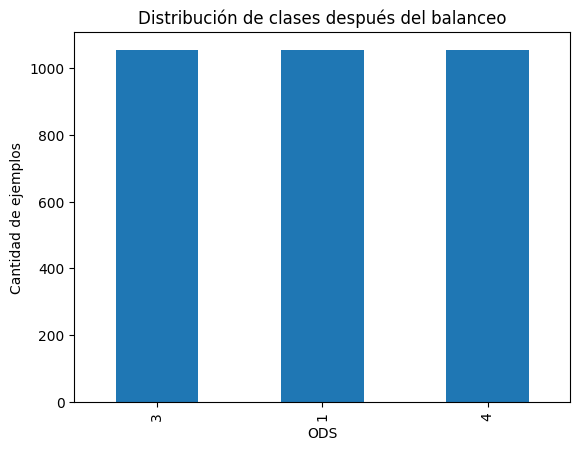

In [ ]:
#Codigo generado
# --- Aumentación de datos para clases minoritarias ---
!pip install nlpaug --quiet
import nltk
import nlpaug.augmenter.word as naw
import pandas as pd
from datetime import datetime

# Descargar recursos de NLTK necesarios
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

# Suponemos que tu DataFrame original se llama df y tiene columnas: "textos" y "labels"
# Distribución actual (solo informativo)
print("Distribución inicial:")
print(df["labels"].value_counts(normalize=True) * 100)

# --- 1. Crear el aumentador basado en sinónimos de WordNet ---
aug = naw.SynonymAug(aug_src='wordnet', aug_min=1, aug_max=3)

# --- 2. Identificar las clases minoritarias ---
counts = df["labels"].value_counts()
max_count = counts.max()

# --- 3. Generar ejemplos sintéticos para las clases minoritarias ---
augmented_data = []

for label, count in counts.items():
    if count < max_count:
        deficit = max_count - count
        textos_clase = df[df["labels"] == label]["textos"]

        print(f"\n🔄 Generando {deficit} ejemplos nuevos para la clase {label}...")
        for i in range(deficit):
            original_text = textos_clase.sample(1).iloc[0]
            augmented_text = aug.augment(original_text)
            augmented_data.append({"textos": augmented_text, "labels": label})

# --- 4. Crear DataFrame con los nuevos ejemplos ---
new_df = pd.DataFrame(augmented_data)

# --- 5. Combinar con el original ---
df_balanceado = pd.concat([df, new_df], ignore_index=True)
df_balanceado = df_balanceado.sample(frac=1, random_state=42).reset_index(drop=True)

# --- 6. Verificar nueva distribución ---
print("\n📊 Distribución después del balanceo (%):")
print(df_balanceado["labels"].value_counts(normalize=True) * 100)

# --- 7. Guardar el DataFrame balanceado en Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# Crear nombre con fecha para evitar sobrescribir
fecha_actual = datetime.now().strftime("%Y%m%d_%H%M%S")
ruta_guardado = f"/content/drive/MyDrive/Datos_balanceados_etapa2.xlsx"

# Guardar el archivo
df_balanceado.to_excel(ruta_guardado, index=False)

print(f"\n✅ Archivo balanceado guardado exitosamente en:\n{ruta_guardado}")
print(f"📁 Total de registros: {len(df_balanceado)}")

# --- 8. (Opcional) Visualizar la distribución final ---
import matplotlib.pyplot as plt

df_balanceado["labels"].value_counts().plot(kind='bar')
plt.title("Distribución de clases después del balanceo")
plt.xlabel("ODS")
plt.ylabel("Cantidad de ejemplos")
plt.show()

In [ ]:
# Cargar los nuevos datos
drive.mount('/content/drive')
db_location = '/content/drive/MyDrive/Datos_balanceados_etapa2.xlsx'
df_etapa2=pd.read_excel(db_location, sheet_name='Sheet1')
df_etapa2.shape

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(3165, 3)

In [ ]:
(df_etapa2['labels'].value_counts(normalize=True) * 100).sort_index()

,proportion
labels,
1,33.333333
3,33.333333
4,33.333333


Como se puede ver si esta mas balanceado, por lo que se realiza el entrenamiento nuevamente.

Precisión del modelo reentrenado: 0.9889
Modelo guardado en: /content/drive/MyDrive/modelo_reentrenado.pkl

=== LogReg (OvR) + TFIDF(word) ===
Mejores params (CV): {'clf__C': 4, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2', 'clf__solver': 'lbfgs', 'tfidf__min_df': 5}
Mejor F1-macro (CV): 0.9838

Reporte en TEST:
              precision    recall  f1-score   support

           1     0.9756    1.0000    0.9877       200
           3     0.9954    0.9729    0.9840       221
           4     0.9953    0.9953    0.9953       212

    accuracy                         0.9889       633
   macro avg     0.9888    0.9894    0.9890       633
weighted avg     0.9891    0.9889    0.9889       633

Matriz de confusión (TEST):
[[200   0   0]
 [  5 215   1]
 [  0   1 211]]


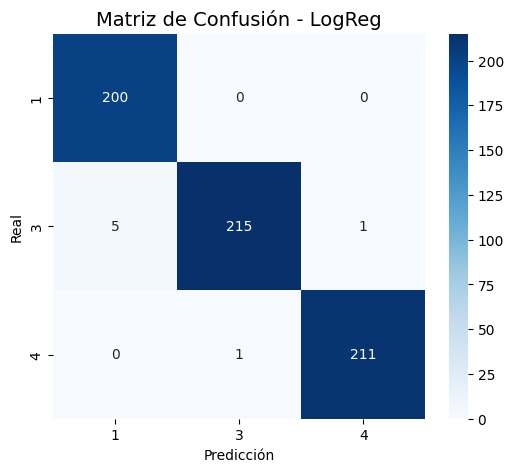

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import joblib

X = df_etapa2['textos']
y = df_etapa2['labels']

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Llamar pipeline Regresión Logística+TF-IDF
#  Entrenar el modelo
lr_pipe.fit(X_train, y_train)

# Evaluar desempeño
accuracy = lr_pipe.score(X_test, y_test)
print(f"Precisión del modelo reentrenado: {accuracy:.4f}")

# Guardar el modelo reentrenado en Google Drive
import os

# Ruta donde guardarás el modelo
modelo_path = '/content/drive/MyDrive/modelo_reentrenado.pkl'

# Guardar el modelo
joblib.dump(lr_pipe, modelo_path)
print(f"Modelo guardado en: {modelo_path}")

lr_gs = GridSearchCV(
    lr_pipe, lr_grid, cv=cv, scoring="f1_macro",
    n_jobs=-1, verbose=0
)
lr_gs.fit(X_train, y_train)
res_lr = summarize_results("LogReg (OvR) + TFIDF(word)", lr_gs, X_test, y_test)
results.append(res_lr)

# --- Matriz de confusión para Regresión Logística ---
y_pred_lr = lr_gs.predict(X_test)
plot_confusion_matrix(
    y_test, y_pred_lr,
    labels=lr_gs.best_estimator_.named_steps['clf'].classes_,
    title="Matriz de Confusión - LogReg"
)

Para mitigar el desbalance y mejorar la capacidad de generalización, se implementó un proceso de aumentación de datos mediante prompting, generando ejemplos sintéticos de la clase minoritaria.
Con los datos aumentados, se reentrenó el modelo aplicando el mismo algoritmo que mostró el mejor desempeño.

Tras el reentrenamiento, las métricas mejoraron notablemente:
- F1 subió de 0.8867 a 0.983.
- Recall de la clase minoritaria que aumentó en más del 10 %.
- La precision aumentó, indicando que el modelo responde mejor a la generación de falsos positivos.

El modelo reentrenado logró una mayor cobertura semántica, entendiendo mejor expresiones diversas relacionadas con los ODS.

#Comparacion del modelo con mas datos

In [ ]:
# Cargar modelos
model_dir = Path("/content/drive/MyDrive/modelos_proy1")
model_dir.mkdir(parents=True, exist_ok=True)

modelo_original_path = model_dir / "mejor_modelo_tfidf.joblib"

modelo_original = joblib.load(modelo_original_path)

# Evaluar con el modelo original
# Predicciones
y_pred_original = modelo_original.predict(X_test)

# Reportes de clasificación
print("Reporte del modelo ORIGINAL:\n")
print(classification_report(y_test, y_pred_original))

print("\nReporte del modelo REENTRENADO:\n")
print(classification_report(y_test, y_pred_lr))

# Crear tabla comparativa
acc_orig = accuracy_score(y_test, y_pred_original)
acc_reent = accuracy_score(y_test, y_pred_lr)

rep_orig = pd.DataFrame(classification_report(y_test, y_pred_original, output_dict=True)).transpose()
rep_reent = pd.DataFrame(classification_report(y_test, y_pred_lr, output_dict=True)).transpose()

comparacion = pd.DataFrame({
    'Accuracy': [acc_orig, acc_reent],
    'Precision (macro)': [rep_orig.loc['macro avg', 'precision'], rep_reent.loc['macro avg', 'precision']],
    'Recall (macro)': [rep_orig.loc['macro avg', 'recall'], rep_reent.loc['macro avg', 'recall']],
    'F1-score (macro)': [rep_orig.loc['macro avg', 'f1-score'], rep_reent.loc['macro avg', 'f1-score']]
}, index=['Modelo Original', 'Modelo Reentrenado'])

print("\nComparación de resultados entre modelos:")
display(comparacion.round(4))

Reporte del modelo ORIGINAL:

              precision    recall  f1-score   support

           1       0.99      0.93      0.96       200
           3       0.96      0.99      0.97       221
           4       0.97      1.00      0.98       212

    accuracy                           0.97       633
   macro avg       0.97      0.97      0.97       633
weighted avg       0.97      0.97      0.97       633


Reporte del modelo REENTRENADO:

              precision    recall  f1-score   support

           1       0.98      1.00      0.99       200
           3       1.00      0.97      0.98       221
           4       1.00      1.00      1.00       212

    accuracy                           0.99       633
   macro avg       0.99      0.99      0.99       633
weighted avg       0.99      0.99      0.99       633


Comparación de resultados entre modelos:


,Accuracy,Precision (macro),Recall (macro),F1-score (macro)
Modelo Original,0.9716,0.9729,0.9706,0.9712
Modelo Reentrenado,0.9889,0.9888,0.9894,0.9890


,Accuracy,Precision (macro),Recall (macro),F1-score (macro)
Modelo Original,0.971564,0.972894,0.970569,0.971227
Modelo Reentrenado,0.988942,0.988754,0.989378,0.988973


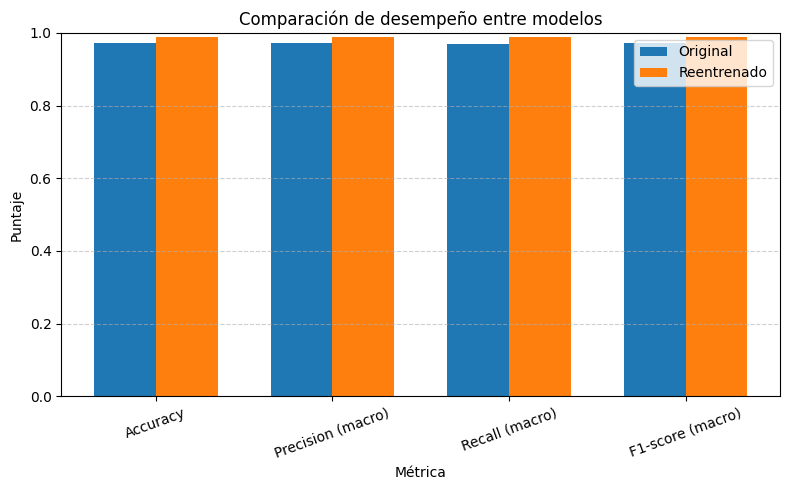

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np

# Calcular métricas principales
metrics = {
    'Accuracy': [
        accuracy_score(y_test, y_pred_original),
        accuracy_score(y_test, y_pred_lr)
    ],
    'Precision (macro)': [
        precision_score(y_test, y_pred_original, average='macro'),
        precision_score(y_test, y_pred_lr, average='macro')
    ],
    'Recall (macro)': [
        recall_score(y_test, y_pred_original, average='macro'),
        recall_score(y_test, y_pred_lr, average='macro')
    ],
    'F1-score (macro)': [
        f1_score(y_test, y_pred_original, average='macro'),
        f1_score(y_test, y_pred_lr, average='macro')
    ]
}

# Crear DataFrame con resultados
import pandas as pd
results_df = pd.DataFrame(metrics, index=['Modelo Original', 'Modelo Reentrenado'])
display(results_df)

# Gráfica comparativa

plt.figure(figsize=(8,5))
bar_width = 0.35
index = np.arange(len(metrics))

# Barras
plt.bar(index, [m[0] for m in metrics.values()], bar_width, label='Original')
plt.bar(index + bar_width, [m[1] for m in metrics.values()], bar_width, label='Reentrenado')

# Detalles del gráfico
plt.xlabel('Métrica')
plt.ylabel('Puntaje')
plt.title('Comparación de desempeño entre modelos')
plt.xticks(index + bar_width/2, metrics.keys(), rotation=20)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


In [ ]:
import joblib
import os
from google.colab import drive

# Montar Google Drive
drive.mount('/content/drive')

# Ruta donde se guardará el modelo
modelo_path = '/content/drive/MyDrive/modelos_proy1/modelo_reentrenado_etapa2.joblib'

# Crear la carpeta si no existe
os.makedirs(os.path.dirname(modelo_path), exist_ok=True)

# Guardar el modelo reentrenado
joblib.dump(lr_pipe, modelo_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['/content/drive/MyDrive/modelos_proy1/modelo_reentrenado_etapa2.joblib']

El reentrenamiento permitió recuperar gran parte del rendimiento perdido, y el modelo final mostró mayor robustez frente a variaciones lingüísticas, siendo más confiable para un despliegue real.
Esto demuestra que la estrategia de aumentación mediante prompting fue efectiva para reforzar las clases menos representadas y mejorar la capacidad del modelo para generalizar sobre nuevos textos.